# Homework 2 (HW2)
By the end of this homework, we expect you to be able to:

- Preprocess data and make it amenable to statistical analysis and machine learning models;
- Train and test out-of-the-box machine learning models in Python;
- Carry out simple multivariate regression analyses;
- Use techniques to control for covariates;
- Conduct an observational study and reason about its results.

---

- Homework release: Fri 17 Nov 2023	

- **Homework Due**: Fri 01 Dec 2023, 23:59	

- Grades released: Mon 11 Dec 2023	


---

## Some rules
1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you may do so, but must justify your choice.

2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you don’t change any of the files.)

3. Be sure to provide a concise textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice.

4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation **(in markdown)**.

5. Back up any hypotheses and claims with data, since this is an important aspect of the course.

6. Please write all your comments in **English**, and use meaningful variable names in your code. Your repo should have a single notebook (plus the required data files) in the master/main branch. **If there are multiple notebooks present, we will not grade anything.**

7. We will **not run your notebook for you!** Rather, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.

8. In continuation to the previous point, interactive plots, such as those generated using the `plotly` package, should be strictly avoided!

9. Make sure to print results and/or dataframes that confirm you have properly addressed the task.


---

In [1]:
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# regression / matching
import statsmodels.formula.api as smf
import networkx as nx

# machine lerning
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder

## Context

After two years, the EPFL Baseball Club is broke. The new Dean transferred all funds to EPFL's new poster child: its super-competitive Pétanque club. After struggling so much to learn about baseball, you have unfortunately been laid off...

*(...) 1 month after, you manage to get another job (!) (...)*

Congratulations! You have just been hired as a data scientist at the Association for Computational Linguistics (ACL), a professional organization for people working on natural language processing. The ACL organizes several of the top conferences and workshops in the field of computational linguistics and natural language processing.
Your boss, Dr. Tiancheng, knows of your expertise in observational studies and asks you to investigate a question that’s been bothering everyone who has ever submitted a paper to a conference: should I spend time on writing rebuttals?



---

## Rebuttals, conferences, and getting your papers accepted

Rebuttals in ACL (Association for Computational Linguistics) conferences and in many other academic conferences are an important part of the peer-review process. They allow authors of submitted papers to respond to the reviews and comments provided by the reviewers before a final decision is made regarding the acceptance of the paper. Here's how the rebuttal process typically works in ACL conferences:

- Paper Submission: Authors submit their research papers to the ACL conference for review. These papers present novel research findings in computational linguistics, natural language processing, and related areas.
- Peer Review: The papers undergo a peer-review process after the initial submission. The program committee or reviewers are experts in the field who evaluate the papers based on their quality, significance, novelty, methodology, and other relevant criteria. They provide comments and scores for each paper.
- Rebuttal Period: After receiving the reviews, authors are given a specific period (usually around a week) to write a rebuttal. The rebuttal is a formal response to the reviewers' comments. It allows authors to clarify misunderstandings, address concerns, and provide additional information to support their paper's quality. 
- Final Review: After receiving the rebuttals, the reviewers may reconsider their initial assessments in light of the authors' responses. Reviewers may choose to maintain or adjust their reviews and scores based on the quality and effectiveness of the author's rebuttal.
- Final Decision: The program committee or conference organizers consider the initial reviews/scores, rebuttals, and revised reviews/scores to make a final decision on the acceptance of the papers. The decision can be acceptance, rejection, or conditional acceptance with a request for revisions.


---

## Data

- `tmp_id`: Unique identifier for each paper in the format "P{number}".
- `status`: Accept or Reject.
- `submission_type`: Short vs. Long (papers can have different lengths). We do not use this column in this homework. 
- `track`: Track to which the paper was submitted, broadly speaking, the "topic" of the paper.
- `scores_before`: Scores received before rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework. 
- `scores_after`: Scores received after rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework.
- `had_rebuttal`: True or False.


Note that: 
 - reviews are assigned numbers, e.g., "2";
 - papers can have different numbers of reviews;
 - review numbers are arbitrary, e.g., `P1` in the dataframe has two reviews numbered "2" and "3" (but no review "1").


## Task 1 (10 pts): Get to Know Your Data

As a good data scientist, you first load the data and perform some small sanity checks on it.

- You are expected to continuously alter your dataframe as you complete the tasks. E.g., if you are asked to filter the data in a specific task, continue using the filtered dataset in the subsequent tasks.
- When we tell you to "print the dataframe," make sure you print it in a way that shows the total number of rows and columns in it (`display(df)` should suffice).

**1.1** Load the dataset containing ACL reviews into memory using pandas. 
- For each paper, create columns `overall_score_before_avg` and `overall_score_after_avg` containing the average (overall) scores before and after rebuttal.
- For each paper, create columns `overall_score_before_std` and `overall_score_after_std` containing the standard deviation of the overall scores before and after the rebuttal.
- Print the four newly created columns for paper `P17`.
- Print the resulting dataframe.

In [2]:
def extract_overall_scores_and_compute(df, score_column):

    #Extract the 'overall_score' from the given column and calculate the mean and standard deviation.
    
    avg_scores = []
    std_scores = []

    for index, row in df.iterrows():
        overall_scores = []
        for reviewer, details in row[score_column].items():            
            overall_score = details['scores'].get('overall_score')
            if overall_score is not None:
                overall_scores.append(overall_score)

        # Calculate the mean score and standard deviation
        avg_scores.append(np.mean(overall_scores) if overall_scores else None)
        std_scores.append(np.std(overall_scores, ddof=1) if len(overall_scores) > 1 else None)  # sample standard deviation

    return avg_scores, std_scores

# Load data
file_path = './data/acl18_v1_numerical_final.json' 
df = pd.read_json(file_path)

# Extract and calculate overall scores
df['overall_score_before_avg'], df['overall_score_before_std'] = extract_overall_scores_and_compute(df, 'scores_before')
df['overall_score_after_avg'], df['overall_score_after_std'] = extract_overall_scores_and_compute(df, 'scores_after')

# Print the relevant columns of paper P17
p17_data = df[df['tmp_id'] == 'P17'][['overall_score_before_avg', 'overall_score_before_std', 'overall_score_after_avg', 'overall_score_after_std']]
print("Relevant data from paper P17:")
print(p17_data)

print("\nSize of data frame (number of rows, number of columns): " + str(df.shape))

display(df)

Relevant data from paper P17:
    overall_score_before_avg  overall_score_before_std  \
16                       4.5                  0.707107   

    overall_score_after_avg  overall_score_after_std  
16                      4.5                 0.707107  

Size of data frame (number of rows, number of columns): (1538, 11)


,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_before_std,overall_score_after_avg,overall_score_after_std
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,2.500000,0.707107,2.500000,0.707107
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.333333,1.154701,3.333333,1.154701
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,4.666667,0.577350,4.666667,0.577350
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.000000,1.000000,2.666667,1.527525
4,P5,Reject,Long,Document Analysis,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,3.000000,NaN,2.500000,0.707107
...,...,...,...,...,...,...,...,...,...,...,...
1540,P1541,Reject,Short,Textual Inference and Other Areas of Semantics,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,2.333333,0.577350,2.333333,0.577350
1541,P1542,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,1.000000,2.000000,1.000000
1542,P1543,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.666667,1.154701,2.666667,1.154701
1543,P1544,Reject,Short,Social Media,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,0.000000,2.000000,0.000000


**1.2** Create a single plot with 14 inches of width and 4 inches of height. The plot should contain two panels: 
- **Panel A**: The distribution of `overall_score_before_avg` for papers that were accepted and papers that were rejected.
- **Panel B**: The distribution of `overall_score_before_avg` for papers that had rebuttals vs. papers that did not.

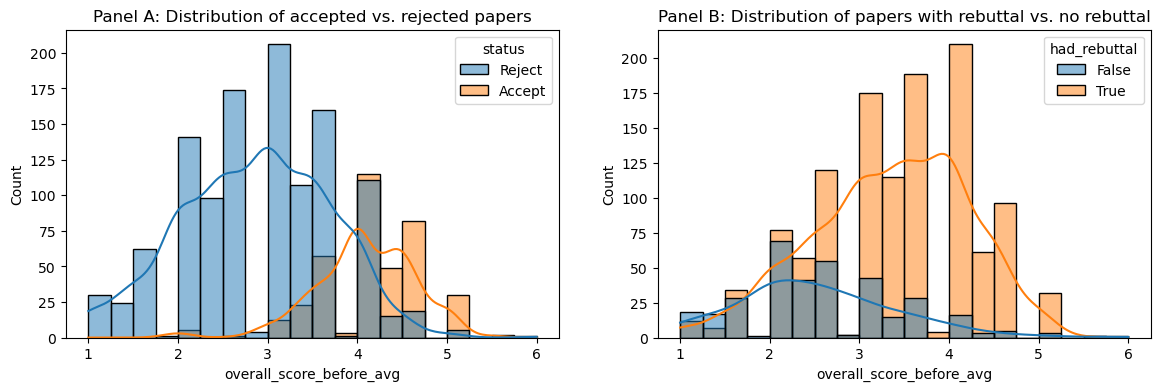

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the size of the chart
plt.figure(figsize=(14, 4))

# Panel A: Distribution of accepted and rejected papers
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='overall_score_before_avg', hue='status', kde=True)
plt.title('Panel A: Distribution of accepted vs. rejected papers')

# Panel B: Distribution of papers with and without rebuttals
plt.subplot(1, 2, 2)  
sns.histplot(data=df, x='overall_score_before_avg', hue='had_rebuttal', kde=True)
plt.title('Panel B: Distribution of papers with rebuttal vs. no rebuttal')

plt.show()

**1.3** **/Discuss/:** If you know a paper had a rebuttal, is it more or less likely that it was accepted? Does this mean that rebuttals help papers get accepted? Explain why or why not, providing a concrete example.

**From data, we can observe a correlation between whether a paper had a rebuttal and whether it was accepted. However, this does not directly imply a causal relationship.**

**Analyzing Correlation:** If the data shows that papers with rebuttals are more likely to be accepted, this indicates a correlation between the two. This can be determined by comparing the acceptance rates of papers with and without rebuttals.

**Exploring Causation:** Even with a correlation, one cannot directly conclude that rebuttals help papers get accepted. There could be other variables influencing the outcome, such as:

    Quality of the Paper: Higher quality papers might inherently have a higher likelihood of acceptance, and -authors of 
    these papers might also be more inclined to submit rebuttals.

    Initial Reviews by Referees: If a paper's initial reviews are borderline (close to the acceptance threshold), authors 
    might be more motivated to submit a rebuttal.

    Quality of the Rebuttal: Not all rebuttals are effective. Some may be more thorough and persuasive than others.

**Conclusion:** While there may be a correlation between rebuttals and paper acceptance, we cannot assert from this data alone that rebuttals are the direct cause of acceptance. To accurately determine causation, a more in-depth analysis is needed, considering additional variables and potential confounding factors. Without further evidence, we can only state that there is a certain correlation between rebuttals and acceptance.

**1.4** Print the percentage of rebuttals per track in the conference (defined by the `track` column). 

**/Discuss:/** Using "the logic" of hypothesis testing (see slide 29 of Lecture 4), how would you devise a statistical test to refute the following null hypothesis: all tracks have the same fraction of papers with rebuttals. Your statistical test should consider all categories at once, rather than comparing the fraction of rebuttals between pairs of categories.

In [4]:
# Calculating the percentage of rebuttals per track
rebuttal_percentages = df.groupby('track')['had_rebuttal'].mean().mul(100).round(4)

# Printing the percentages
print(rebuttal_percentages)

track
Dialogue and Interactive Systems                                77.5281
Discourse and Pragmatics                                        80.4348
Document Analysis                                               73.0000
Generation                                                      77.9661
Information Extraction and Text Mining                          76.8362
Linguistic Theories Cognitive Modeling and Psycholinguistics    75.0000
Machine Learning                                                80.8696
Machine Translation                                             82.0755
Multidisciplinary and Area Chair COI                            68.0000
Multilinguality                                                 80.6452
Phonology Morphology and Word Segmentation                      85.1852
Question Answering                                              72.8395
Resources and Evaluation                                        73.2394
Sentence-level semantics                                  

To test the null hypothesis that all tracks have the same fraction of papers with rebuttals, we need a statistical test that considers all categories (tracks) simultaneously. One appropriate test for this is the Chi-Square Test of Independence.

**Test Description:**

    1.Null Hypothesis (H0): The fraction of papers with rebuttals is the same across all tracks.
    2.Alternative Hypothesis (H1): At least one track has a different fraction of papers with rebuttals compared to others.
**Steps:**
    
    1.Create a Contingency Table: The table should have tracks as rows and two columns representing the counts of papers with and without rebuttals for each track.
    2.Apply the Chi-Square Test: Use the contingency table to perform the test. The test will compare the observed counts of papers with and without rebuttals in each track to the counts expected if the null hypothesis were true.
    3.Evaluate the P-Value: Determine the significance of the result using a chosen alpha level (e.g., 0.05). A p-value less than alpha would lead to rejecting the null hypothesis, suggesting that the fraction of papers with rebuttals is not the same across all tracks.

## Task 2 (10pts): Prediction

You decide to investigate further the effect of rebuttals on acceptance using your machine learning skills.


**2.1** For each possible value in the `track` column, create a new column called {track}-onehot (e.g., for track=Generation, create Generation-onehot). Collectively, these new columns should "one hot-encode" the track column---for instance, if for a given paper the `track` column is filled with the value "Generation", the Generation-onehot column should equal 1 and all other {track}-onehot columns should equal 0. 

Print the column names of the resulting dataframe.

In [5]:
# Initializing the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop=None)

# Fitting and transforming the 'track' column
track_encoded = encoder.fit_transform(df[['track']])

# Creating a DataFrame from the encoded data
track_encoded_df = pd.DataFrame(track_encoded, columns=encoder.get_feature_names_out(['track']))

# Renaming columns to the format "{track}-onehot"
track_encoded_df.columns = [f'{col}-onehot' for col in track_encoded_df.columns]

# Merge the one-hot encoded columns back to the main DataFrame
df = pd.concat([df.reset_index(drop=True), track_encoded_df.reset_index(drop=True)], axis=1)

# Print the column names of the resulting DataFrame
print(df.columns)

Index(['tmp_id', 'status', 'submission_type', 'track', 'scores_before',
       'scores_after', 'had_rebuttal', 'overall_score_before_avg',
       'overall_score_before_std', 'overall_score_after_avg',
       'overall_score_after_std',
       'track_Dialogue and Interactive Systems-onehot',
       'track_Discourse and Pragmatics-onehot',
       'track_Document Analysis-onehot', 'track_Generation-onehot',
       'track_Information Extraction and Text Mining-onehot',
       'track_Linguistic Theories Cognitive Modeling and Psycholinguistics-onehot',
       'track_Machine Learning-onehot', 'track_Machine Translation-onehot',
       'track_Multidisciplinary and Area Chair COI-onehot',
       'track_Multilinguality-onehot',
       'track_Phonology Morphology and Word Segmentation-onehot',
       'track_Question Answering-onehot',
       'track_Resources and Evaluation-onehot',
       'track_Sentence-level semantics-onehot',
       'track_Sentiment Analysis and Argument Mining-onehot',
      


**2.2** Create a column `had_rebuttal_int`, which equals 1 if the paper had a rebuttal, and 0 otherwise, and a column `accepted_int`, which equals 1 if the paper was accepted, and 0 otherwise. 

In [6]:
# Convert 'had_rebuttal' to integers (1 if True, 0 if False)
df['had_rebuttal_int'] = df['had_rebuttal'].astype(int)

# Convert 'status' to integers (1 if 'Accept', 0 if 'Reject')
df['accepted_int'] = (df['status'] == 'Accept').astype(int)

**2.3** Create a function `numpy_helper(df, cols)` to obtain a numpy.array out of your dataframe. The function should receive a dataframe `df` with N rows and a list of M columns `cols`, and should return a `np.array` of dimension `(NxM)` cast as a float.

In [7]:
def numpy_helper(df, cols):
    """
    Extract specified columns from a DataFrame and return them as a NumPy array.
    
    :param df: pandas DataFrame from which to extract data.
    :param cols: List of column names to extract.
    :return: NumPy array of extracted data, cast as float.
    """
    return df[cols].values.astype(float)


**2.4**
Create:
- an array of features X containing all track one-hot features, as well as the `overall_score_before_avg`,`overall_score_before_std`, and `had_rebuttal_int`;
- an array of outcomes y containing `accepted_int`. 


Print the shapes of both X and y (e.g., `X.shape`).

In [8]:
# Define the one-hot encoded track columns
track_onehot_cols = [col for col in df.columns if '-onehot' in col]

# Define the feature columns including the one-hot encoded tracks, overall scores, and had_rebuttal_int
feature_cols = track_onehot_cols + ['overall_score_before_avg', 'overall_score_before_std', 'had_rebuttal_int']

# Prepare the feature matrix X
X = df[feature_cols].values.astype(float)

# Prepare the outcome vector y
y = df['accepted_int'].values.astype(float)

# Print the shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1538, 24)
Shape of y: (1538,)



**2.5** Build two `GradientBoostingClassifier` models using `sklearn` using the default parameters:
- Model 1: predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`,`overall_score_before_std`.
- Model 2:  predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`,`overall_score_before_std` **and** `had_rebuttal_int`.


For both models:

- Use the `cross_validate` function from `sklearn.model_selection` to compute the average precision, recall, and accuracy across test cross validation splits.

    - e.g., `cross_validate(clf, X, y, cv=30, scoring=('accuracy', 'precision', 'recall'))`

For this task, the `SimpleImputer` package is utilized to handle missing values in the dataset, a necessary step before applying the `GradientBoostingClassifier`. Machine learning models generally cannot process missing values (`NaN`s), which can lead to errors or poor performance. `SimpleImputer` resolves this by replacing missing values with the mean of each column, ensuring data consistency and integrity for the model's training and evaluation. This approach is both straightforward and efficient, making it a standard practice in preparing datasets for machine learning tasks.

In [9]:
from sklearn.impute import SimpleImputer

# Imputer to fill NaN values
imputer = SimpleImputer(strategy='mean')

# Prepare the feature sets for both models
X_1 = imputer.fit_transform(X[:, :-1])
X_2 = imputer.fit_transform(X)

# Initialize the Gradient Boosting Classifier model
clf = GradientBoostingClassifier()

# Cross-validation for Model 1
cv_results_1 = cross_validate(clf, X_1, y, cv=30, scoring=('accuracy', 'precision', 'recall'))
average_scores_1 = {metric: np.mean(scores) for metric, scores in cv_results_1.items() if metric.startswith('test_')}

# Cross-validation for Model 2
cv_results_2 = cross_validate(clf, X_2, y, cv=30, scoring=('accuracy', 'precision', 'recall'))
average_scores_2 = {metric: np.mean(scores) for metric, scores in cv_results_2.items() if metric.startswith('test_')}

# Print the average scores for both models
print("Average scores for Model 1:", {k: round(v, 4) for k, v in average_scores_1.items()})
print("Average scores for Model 2:", {k: round(v, 4) for k, v in average_scores_2.items()})

Average scores for Model 1: {'test_accuracy': 0.8282, 'test_precision': 0.6883, 'test_recall': 0.5797}
Average scores for Model 2: {'test_accuracy': 0.8269, 'test_precision': 0.6808, 'test_recall': 0.5771}



**2.6** Determine whether the difference in accuracy of the two models is statistically significant.


For this part of the task, we import `ttest_rel` from `scipy.stats` to perform a paired t-test, which is crucial for evaluating the statistical significance of the difference in accuracy between the two Gradient Boosting Classifier models. A paired t-test is appropriate here because it compares two related samples: the accuracies of two models tested on the same dataset. This test helps determine if any observed difference in model performance is due to chance or is statistically significant. The t-test's p-value, when compared against a chosen significance level (alpha = 0.05 here), indicates whether the difference in accuracies is statistically meaningful. This statistical method is essential for robustly validating the impact of including an additional feature (`had_rebuttal_int`) in the predictive modeling.

In [10]:
from scipy.stats import ttest_rel

# Extract accuracy scores from cross-validation results for both models
accuracies_model_1 = cv_results_1['test_accuracy']
accuracies_model_2 = cv_results_2['test_accuracy']

# Perform a paired t-test
t_statistic, p_value = ttest_rel(accuracies_model_1, accuracies_model_2)

# Print the t-statistic and p-value
print(f"T-statistic: {t_statistic}, P-value: {p_value}")

# Interpret the p-value
alpha = 0.05  
if p_value < alpha:
    print("The difference in accuracy is statistically significant.")
else:
    print("The difference in accuracy is not statistically significant.")

T-statistic: 0.40021446015491163, P-value: 0.6919315270063608
The difference in accuracy is not statistically significant.


**2.7** **/Discuss:/** Contrast the results obtained in **2.6** with what you observed in **Task 1**. What advantage did the analyses in **2.6** have?

In Task 1, the focus was on exploratory data analysis, including visualizations and basic statistical summaries. This provided valuable insights into general trends and patterns, such as the distribution of scores and the proportion of papers with rebuttals. However, it was limited to descriptive statistics and lacked a quantifiable measure of the impact of rebuttals on paper acceptance.

Contrastingly, in Task 2.6, a more rigorous and quantitative approach was employed. Two machine learning models were built and evaluated using cross-validation, and a statistical test (paired t-test) was conducted to determine the significance of the difference in their accuracies. This approach allowed for a quantitative assessment of the impact of including the `had_rebuttal_int` feature in the prediction of paper acceptance. It provided objective comparison metrics such as precision, recall, and accuracy, offering a multi-faceted view of model performance. The use of a paired t-test for statistical significance testing added a layer of robustness to the analysis, which was absent in Task 1.

The advantage of the analyses in Task 2.6 lies in its **quantitative assessment**, allowing for **a more objective and statistically sound evaluation** of how rebuttals affect paper acceptance. While Task 1's **descriptive analysis** offered foundational insights, Task 2.6's **predictive modeling and statistical testing** provided a deeper, more nuanced understanding of the dataset and the research question. This combination of descriptive and predictive analyses offers a comprehensive view, where each approach complements the other to provide a fuller picture.

## Task 3 (12pts): Interlude



**3.1** Using the formula API from `statsmodels`, estimate the following linear regressions. Report the summary of the models.
- `accepted_int ~ had_rebuttal_int`,  
- `accepted_int ~ overall_score_after_avg`
- `had_rebuttal_int ~ overall_score_before_avg`

In [11]:
# Perform linear regression to the models
model1 = smf.ols(formula="accepted_int ~ had_rebuttal_int", data=df).fit()
model2 = smf.ols(formula="accepted_int ~ overall_score_after_avg", data=df).fit()
model3 = smf.ols(formula="had_rebuttal_int ~ overall_score_before_avg", data=df).fit()

# Print summary
print(f"Regression model 1 Summary:\n{model1.summary()}\n")
print(f"Regression model 2 Summary:\n{model2.summary()}\n")
print(f"Regression model 3 Summary:\n{model3.summary()}")

Regression model 1 Summary:
                            OLS Regression Results                            
Dep. Variable:           accepted_int   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     66.22
Date:                Thu, 30 Nov 2023   Prob (F-statistic):           8.24e-16
Time:                        14:42:24   Log-Likelihood:                -855.16
No. Observations:                1538   AIC:                             1714.
Df Residuals:                    1536   BIC:                             1725.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept   


**3.2** **/Discuss:/** Interpret the coefficients associated with the binary independent variable in the above models. Note that independent variables are the ones on the right-handside of the equation.

- e.g., in `had_rebuttal_int ~ overall_score_before_avg`, `overall_score_before_avg` is the independent variable.



Only model 1 has a binary independent variable `had_rebuttal_int`, which takes 1 if the paper had a rebuttal, and 0 otherwise. 
- **Model 1: accepted_int ~ had_rebuttal_int**  
  The coefficient of model 1, 0.2098, indicates that for every one-unit increase in `had_rebuttal_int`, the `accepted_int` increases by an average of 0.2098 units. This suggests that having a rebuttal positively influences the likelihood of acceptance. 
  The intercept represents the expected value of the dependent variable `accepted_int` when the independent variable `had_rebuttal_int` is equal to 0. In this case, when a paper did not have a rebuttal, the expected value of `accepted_int` is approximately 0.084.


**3.3** **/Discuss:/** describe three correlations you can draw from the previous analysis. Describe their sign (i.e., whether they are positive or negative), and whether they are statistically significant (at the .05 level of significance).


- **`had_rebuttal_int` and `accepted_int`**  
    A positive and statistically significant correlation exists between having a rebuttal (had_rebuttal_int) and the acceptance of an argument (accepted_int). Arguments that have a rebuttal are more likely to be accepted. The coefficient for `had_rebuttal_int` in the regression analysis is estimated to be between 0.159 and 0.260 at a 95% confidence level. Since the confidence interval does not include zero and is entirely positive, it reinforces the notion that the presence of a rebuttal significantly contributes to the higher acceptance rate of arguments.
- **`overall_score_after_avg` and `accepted_int`**  
    There is a positive and statistically significant correlation between the `overall_score_after_avg` and the acceptance of an argument (`accepted_int`). Higher `overall_score_after_avg` is associated with a greater likelihood of argument acceptance. The coefficient for `overall_score_after_avg` in the regression analysis is estimated to be between 0.269 and 0.303 at a 95% confidence level. Since the confidence interval does not include zero and is entirely positive, we are strongly confident that they have a positive correlation.

- **`overall_score_before_avg` and `had_rebuttal_int`**  
    The correlation between the presence of a rebuttal (`had_rebuttal_int`) and `overall_score_before_avg` is positive and statistically significant. Higher `overall_score_before_avg` are associated with a higher probability of having a rebuttal. The coefficient for `overall_score_before_avg` and `had_rebuttal_int` in the regression analysis is estimated to be between 0.144 and 0.186 at a 95% confidence level. Since the confidence interval does not include zero and is entirely positive, we are strongly confident that arguments with a rebuttal are more likely to happen with higher overall score before.

**3.4** **/Discuss:/** Is the following statement True or False? Justify. 

- The variable `overall_score_after_avg` explains more of the variance in `accepted_int`than the variable `overall_score_before_avg` explains of `had_rebuttal_int`.


It's Ture.  

R-squared serves as a crucial metric in regression analysis, indicating the extent to which a regression model explains the variance in observed data. The closer the value is to 1, the better the model explains the data's variance, whereas values closer to 0 indicate a weaker ability to explain variance. 

While the R-squared for `overall_score_after_avg` and `accepted_int` has the value of 0.402, the R-squared for overall_score_before_avg and had_rebuttal_int is only 0.135. It implies that `overall_score_after_avg` explains a larger proportion of the variance in `accepted_int` compared to `overall_score_before_avg` explaining the variance in `had_rebuttal_int`. Hence, the statement is True.


**3.5** **/Discuss:/** Create a causal diagram relating the following variables:
- "Sa": `overall_score_after_avg`
- "Sb": `overall_score_before_avg`
- "Re": `had_rebuttal_int`
- "Ac": `accepted_int`
- "Tr": `track`


When unsure about whether a causal relationship exists, include it in the diagram. E.g., include the arrow corresponding to the key questions around this homework, i.e., `had_rebuttal_int`->`accepted_int`, even though you are investigating whether it exists. 

You may draw your diagram using text, use Sa/Sb/Re/Ac/Tr to represent the names of the variables, and simply indicate the causal links, one per line.


Instead of drawing something like this:
![](./dagv.jpeg)

Simply write:

- Tr->Sb
- Tr->Ac
- Tr->Re
- Ac->Sb
- Re->Sb
- Sb->Sa

---

- Re -> Ac
- Sa -> Ac
- Sb -> Re  
uncertain relationship:  
- Re -> Sa 
- Tr -> Ac
- Tr -> Re
- Tr -> Sa
- Tr -> Sb

**3.6** **/Discuss:/** What is the problem of simply comparing the outcomes of papers that had rebuttals with those that did not? Give a concrete example.

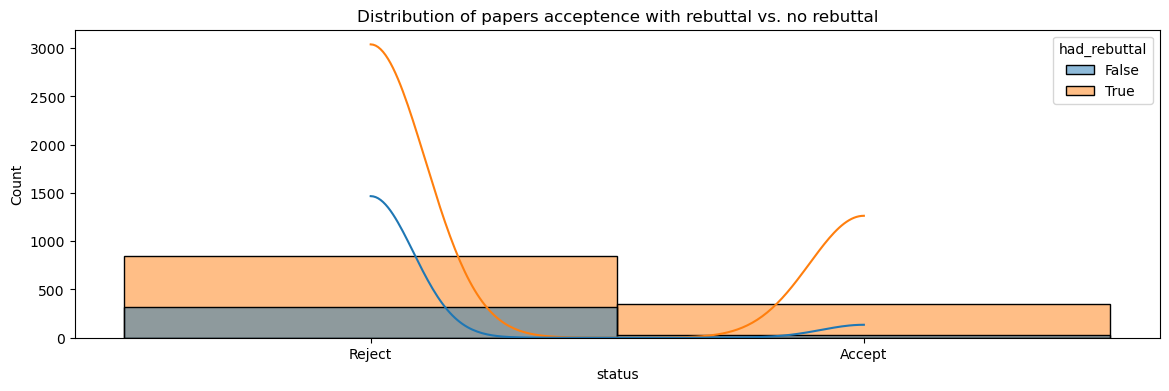

In [12]:
# Setting the size of the chart
plt.figure(figsize=(14, 4))

# Distribution of papers acceptence with and without rebuttals
sns.histplot(data=df, x='status', hue='had_rebuttal', kde=True)
plt.title('Distribution of papers acceptence with rebuttal vs. no rebuttal')

plt.show()

**Problem**:  
Simply comparing the outcomes of papers had rebuttals with those did not can lead to a biased analysis and inaccurate conclusions, because papers that provide rebuttals are not randomly assigned to that group, variables of these two groups are not matched.

**Example**:  
Papers are accepted or rejected based on a review process, those receiving positive reviews can be accepted without rebuttals, while papers with negative reviews are subject to rebuttal and potential acceptance based on revisions. The criteria for assigning papers to the rebuttal group are not random but are based on the initial reviews.  
Based on the previous analysis, we find that papers with rebuttals usually have lower acceptance rates and lower overall scores, concluding that rebutted papers perform worse. However, this conclusion is not accurate because the two groups of papers are not comparable. The papers that had rebuttals initially received worse reviews, which is the reason they provide a rebuttal. On the other hand, excellent papers accepted without rebuttals tended to receive positive reviews.  
In this case, the non-random assignment of papers to the two groups introduces a selection bias. Papers in the rebuttal group are likely to have lower initial scores, not because they are inherently worse, but because their assignment to the group of articles that provided a rebuttal depends on their initial reviews. To address this problem, we should perform matching on two groups to prevent the selection bias and obtain more accurate comparisons between the two groups.

# Task 4 (12 pts): Observational study

You decide to use your observational study skills to obtain a concrete answer to the question: do rebuttals increase acceptance?

 **4.1** Perform exact one-to-one matching considering the `overall_score_before_avg` and the `track` variables. Each paper that had a rebuttal ("treatment group") should be matched to a paper that did not have a rebuttal ("control group"). 
- Your matching should be optimal, i.e., the maximum amount of papers possible must be matched. 
- Print the dataframe of papers in the matched sample

- The `NearestNeighbors` package from scikit-learn is import to efficiently find the closest match in a dataset based on specified criteria. Imported at the beginning, it is used in the `perform_matching` function to pair each paper with a rebuttal (treatment group) with the most similar paper without a rebuttal (control group), based on the 'overall_score_before_avg'. This method ensures precise and relevant matching within the same 'track', essential for comparing the effects of rebuttals in an observational study.

- In the resulting DataFrame, the matching is represented by the arrangement of the rows. Each treatment case (a paper with a rebuttal) is followed by its closest match from the control group (a paper without a rebuttal)

In [13]:
from sklearn.neighbors import NearestNeighbors

def perform_matching(df, treatment_condition, track_var, score_var):
    """
    Perform one-to-one matching between treatment and control groups based on a specific track 
    and the nearest neighbor score, ensuring optimal matching.

    :param df: DataFrame containing the data.
    :param treatment_condition: Boolean series to identify the treatment group.
    :param track_var: Column name for the track variable.
    :param score_var: Column name for the score variable used in matching.
    :return: DataFrame containing the matched treatment and control pairs.
    """
    treatment_group = df[treatment_condition]
    control_group = df[~treatment_condition]
    nn = NearestNeighbors(n_neighbors=1, algorithm='auto')  # Initialized once

    matched_pairs = []
    for track in treatment_group[track_var].unique():
        # Filter both groups for the current track
        treatment_track_group = treatment_group[treatment_group[track_var] == track]
        control_track_group = control_group[control_group[track_var] == track]

       
        # Fit NearestNeighbors on the control group
        nn.fit(control_track_group[[score_var]])

        for _, treatment_row in treatment_track_group.iterrows():
            # Find nearest neighbor in control group
            treatment_score_df = pd.DataFrame([treatment_row[score_var]], columns=[score_var])
            _, nearest_index = nn.kneighbors(treatment_score_df)

            if nearest_index.size > 0 and nearest_index[0][0] < len(control_track_group):
                nearest_control_idx = control_track_group.iloc[nearest_index[0]].index.item()

                # Pair the treatment case with the matched control case
                matched_pairs.append(treatment_row.to_dict())
                matched_pairs.append(control_track_group.loc[nearest_control_idx].to_dict())

                # Remove the matched control case from further consideration
                control_track_group = control_track_group.drop(nearest_control_idx)

    return pd.DataFrame(matched_pairs)

# Usage of the function
matched_sample = perform_matching(df, df['had_rebuttal'], 'track', 'overall_score_before_avg')

display(matched_sample)

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_before_std,overall_score_after_avg,...,track_Sentence-level semantics-onehot,track_Sentiment Analysis and Argument Mining-onehot,track_Social Media-onehot,track_Summarization-onehot,track_Tagging Chunking Syntax and Parsing-onehot,track_Textual Inference and Other Areas of Semantics-onehot,track_Vision Robotics Multimodal Grounding and Speech-onehot,track_Word-level Semantics-onehot,had_rebuttal_int,accepted_int
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,2.500000,0.707107,2.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,P193,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.500000,0.707107,2.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.000000,1.000000,2.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,P272,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 3, 'soundness...","{'2': {'scores': {'originality': 3, 'soundness...",False,3.000000,0.000000,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,P25,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,3.000000,1.414214,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,P838,Reject,Long,Social Media,"{'1': {'scores': {'originality': 5, 'soundness...","{'1': {'scores': {'originality': 5, 'soundness...",False,3.333333,1.154701,3.333333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0
648,P934,Accept,Long,Social Media,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,3.000000,1.414214,4.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1
649,P1001,Reject,Long,Social Media,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,3.000000,0.000000,3.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0
650,P955,Reject,Long,Social Media,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,3.000000,1.414214,3.666667,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0


**4.2** So far, we did not consider the `overall_score_before_std` variable. One could argue that the variance in the scores makes a difference. E.g., a paper that received scores 1 and 5, might be very different from a paper with scores 3 and 3. 

Note that you did not match on the `overall_score_before_std` variable. However, it suffices if this variable is "balanced" across treatment and control groups.
 Use the Standardized Mean Difference (SMD) to assess whether that's the case.

- The standardized mean difference for a variable $x$ and two groups $t$ and $c$ is defined as: $\frac{| E[x_t] - E[x_c] |}{\sqrt{Var[x_t] + Var[x_c]}}$

- Note that a Standardized Mean Difference smaller than 0.1 suggests that variables are balanced across treatment and control groups.


In [14]:
def calculate_smd(df, treatment_condition, variable):
    """
    Calculate the Standardized Mean Difference (SMD) for a given variable
    between treatment and control groups.

    :param df: DataFrame containing the data.
    :param treatment_condition: Boolean series to identify the treatment group.
    :param variable: The variable for which to calculate the SMD.
    :return: The Standardized Mean Difference.
    """
    # Separate the treatment and control groups
    treatment_group = df[treatment_condition]
    control_group = df[~treatment_condition]

    # Calculate means and variances
    mean_treatment = treatment_group[variable].mean()
    mean_control = control_group[variable].mean()
    var_treatment = treatment_group[variable].var()
    var_control = control_group[variable].var()

    # Calculate SMD
    smd = abs(mean_treatment - mean_control) / (var_treatment + var_control)**0.5
    return smd

smd_overall_score_before_std = calculate_smd(matched_sample, matched_sample['had_rebuttal'], 'overall_score_before_std')
print(smd_overall_score_before_std)

0.037324233921244926


Since the value is smaller than 0.1, it suggest that the `overall_score_before_std` variable is balanced across treatment and control groups.


**4.3** Using the matched sample, estimate the following linear regression: `accepted ~ had_rebuttal_int`.


In [15]:
formula = 'accepted_int ~ had_rebuttal_int'

model = smf.ols(formula=formula, data=matched_sample).fit()
model_summary = model.summary()

print(model_summary)

                            OLS Regression Results                            
Dep. Variable:           accepted_int   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     12.00
Date:                Thu, 30 Nov 2023   Prob (F-statistic):           0.000566
Time:                        14:42:26   Log-Likelihood:                -219.03
No. Observations:                 652   AIC:                             442.1
Df Residuals:                     650   BIC:                             451.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0890      0.019  


**4.4** **/Discuss:/**

i. Considering your results obtained in 4.3, and the causal diagram drawn in Task 3: do rebuttals increase the chance of a paper getting accepted? Why are results different from what you obtained in **Task 1?**

ii. Why is there no need to include other covariates (e.g., score before) in the regression?

i. 
The analysis in Task 4.3 reveals a significant positive effect of rebuttals on paper acceptance. Unlike Task 1, which primarily offered correlational insights, Task 4.3 employs a matched sample, controlling for overall_score_before_avg and track. This matching mitigates confounding influences, allowing for a more accurate estimation of the impact of rebuttals. The positive coefficient for had_rebuttal_int in the regression model suggests that papers with rebuttals have a higher likelihood of acceptance, indicating that rebuttals play a beneficial role in the acceptance process.

ii.
In Task 4.3, the regression model excludes additional covariates like overall_score_before_avg due to the matched sample design, which already balances these variables between papers with and without rebuttals. This matching ensures any observed effects on acceptance are attributable to rebuttals rather than uncontrolled factors. Thus, the inclusion of these covariates in the regression is unnecessary, as the matching effectively controls for potential confounders.

**4.5** **/Discuss:/** Imagine there is another, unobserved variable "quality" which captures the true quality of the paper. Suppose quality ("Qu") is connected to the DAG you drew in the following ways:
- Qu -> Sa
- Qu -> Sb
- Qu -> Re
- Qu -> Ac
Assume that
- quality can only increase the chances of rebuttals;
- quality and the rebuttal can only increase the chance of a paper being accepted.
Does this uncontrolled confounder threaten the validity of your findings?


The uncontrolled confounder "quality" poses a significant threat to the validity of the findings in Task 4.3. This unobserved variable, influencing both the likelihood of a rebuttal and paper acceptance, might lead to a spurious association between rebuttals and acceptance. In essence, higher intrinsic quality could drive both the inclination to rebut and the chances of acceptance, thereby confounding the observed relationship. Without accounting for this hidden factor, conclusions drawn about the efficacy of rebuttals on acceptance remain uncertain and potentially misleading.